<a href="https://colab.research.google.com/github/TillVollmer5/mass_spectroscopy/blob/main/Qualitative_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pandas as pd
import seaborn as sns

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
Auto_1_pm_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto1_PF_120k_125.csv')
Auto_1_gp_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto1_PUF_hc_120k_138.csv')
Auto_2_gp_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto2_PF_120k_147.csv')
Auto_2_pm_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto2_PUF_120k_149.csv')
Auto_3_gp_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto3_PUF_120k_165.csv')
Auto_3_pm_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto3_PF_120k_170.csv')
QC_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_QC_Solvent_95_5_120k_169.csv')

In [3]:
Auto_1_pm_df['Ion Type'] = 'pm'
Auto_1_gp_df['Ion Type'] = 'gp'
Auto_2_gp_df['Ion Type'] = 'gp'
Auto_2_pm_df['Ion Type'] = 'pm'
Auto_3_gp_df['Ion Type'] = 'gp'
Auto_3_pm_df['Ion Type'] = 'pm'

Auto_1_pm_df['Sample Name'] = 'Auto_1'
Auto_1_gp_df['Sample Name'] = 'Auto_1'
Auto_2_gp_df['Sample Name'] = 'Auto_2'
Auto_2_pm_df['Sample Name'] = 'Auto_2'
Auto_3_gp_df['Sample Name'] = 'Auto_3'
Auto_3_pm_df['Sample Name'] = 'Auto_3'

In [4]:
def drop_nan_rows(dataframe):
    """
    Drop rows where the elemental composition is NaN.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with NaN rows removed.
    """
    return dataframe.dropna(subset=['Formula'])

def check_duplicate_rows(dataframe, retention_time_threshold=3, mass_threshold=10):
    """
    Check for duplicate rows based on retention time and monoisotopic mass.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame.
    retention_time_threshold (float): Retention time threshold in minutes.
    mass_threshold (float): Mass threshold.

    Returns:
    pd.DataFrame: DataFrame with duplicate rows removed.
    """

    # Define the conditions for considering rows as duplicates
    conditions = [(dataframe['Retention Time'].duplicated(keep=False) & ((dataframe['Retention Time'] - dataframe['Retention Time'].shift()).abs() <= retention_time_threshold) & (dataframe['M/Z'].duplicated(keep=False) & (dataframe['M/Z'] - dataframe['M/Z'].shift()).abs() <= mass_threshold))]

    dataframe = dataframe[~pd.concat(conditions, axis=1).any(axis=1)].copy()

    return dataframe

def qc_removal(auto_df, qc_df, retention_time_threshold=35, mass_threshold=10):
    """
    Compare each row in the Auto DataFrame with the corresponding retention time in the QC DataFrame.
    Drop the row if the retention time is within the threshold and the monoisotopic mass is the same.

    Parameters:
    auto_df (pd.DataFrame): Auto DataFrame.
    qc_df (pd.DataFrame): QC DataFrame.
    retention_time_threshold (float): Retention time threshold in minutes.
    mass_threshold (float): Mass threshold.

    Returns:
    pd.DataFrame: Updated Auto DataFrame with rows dropped based on QC criteria.
    """
    auto_df_copy = auto_df.copy()

    for index, auto_row in auto_df.iterrows():
        qc_row = qc_df[(qc_df['Retention Time'] - auto_row['Retention Time']).abs() <= retention_time_threshold]

        if not qc_row.empty:
            if abs(qc_row.iloc[0]['M/Z'] - auto_row['M/Z']) <= mass_threshold:
                auto_df_copy = auto_df_copy.drop(index)

    return auto_df_copy

def process_auto_dfs(auto_dfs, threshold=1):
    """
    Process a list of Auto DataFrames according to the specified criteria.

    Parameters:
    auto_dfs (list): List of Auto DataFrames.
    threshold (float): Retention time threshold for duplicates.

    Returns:
    pd.DataFrame: Processed DataFrame with comparison columns.
    """
    processed_df = pd.DataFrame()

    print("Step 1: Created an empty DataFrame.")
    print("Shape of Processed DataFrame:", processed_df.shape)

    for auto_df in auto_dfs:
        processed_df = processed_df.append(auto_df, ignore_index=True)

    print("\nStep 2-3: Appended rows from each Auto DataFrame.")
    print("Shape of Processed DataFrame after appending:", processed_df.shape)

    processed_df.drop_duplicates(subset=['Retention Time', 'Elemental Composition'], inplace=True)

    print("\nStep 4: Dropped duplicates based on retention time and elemental composition.")
    print("Shape of Processed DataFrame after dropping duplicates:", processed_df.shape)

    processed_df.sort_values(by='Retention Time', inplace=True)

    print("\nStep 5: Sorted DataFrame based on retention time.")
    print("Shape of Processed DataFrame after sorting:", processed_df.shape)

    for i, auto_df in enumerate(auto_dfs, start=1):
        col_name = f'Match_{i}'
        processed_df[col_name] = False

        print(f"\nStep 7: Created '{col_name}' column with False values.")
        print("Shape of Processed DataFrame after adding match column:", processed_df.shape)

        for index, row in processed_df.iterrows():
            match_condition = (abs(auto_df['Retention Time'] - row['Retention Time']) <= threshold) & (auto_df['Elemental Composition'] == row['Elemental Composition'])

            if match_condition.any():
                processed_df.at[index, col_name] = True

        print("\nStep 10: Updated match columns.")
        print("Shape of Processed DataFrame after updating match columns:", processed_df.shape)

    print("\nFinal Processed DataFrame:")
    print("Shape of Processed DataFrame:", processed_df.shape)

    return processed_df

In [5]:
Auto_1_pm_df = drop_nan_rows(Auto_1_pm_df)
Auto_1_pm_df = check_duplicate_rows(Auto_1_pm_df)

Auto_1_gp_df = drop_nan_rows(Auto_1_gp_df)
Auto_1_gp_df = check_duplicate_rows(Auto_1_gp_df)

Auto_2_gp_df = drop_nan_rows(Auto_2_gp_df)
Auto_2_gp_df = check_duplicate_rows(Auto_2_gp_df)

Auto_2_pm_df = drop_nan_rows(Auto_2_pm_df)
Auto_2_pm_df = check_duplicate_rows(Auto_2_pm_df)

Auto_3_gp_df = drop_nan_rows(Auto_3_gp_df)
Auto_3_gp_df = check_duplicate_rows(Auto_3_gp_df)

Auto_3_pm_df = drop_nan_rows(Auto_3_pm_df)
Auto_3_pm_df = check_duplicate_rows(Auto_3_pm_df)

QC_df = drop_nan_rows(QC_df)
QC_df = check_duplicate_rows(QC_df)

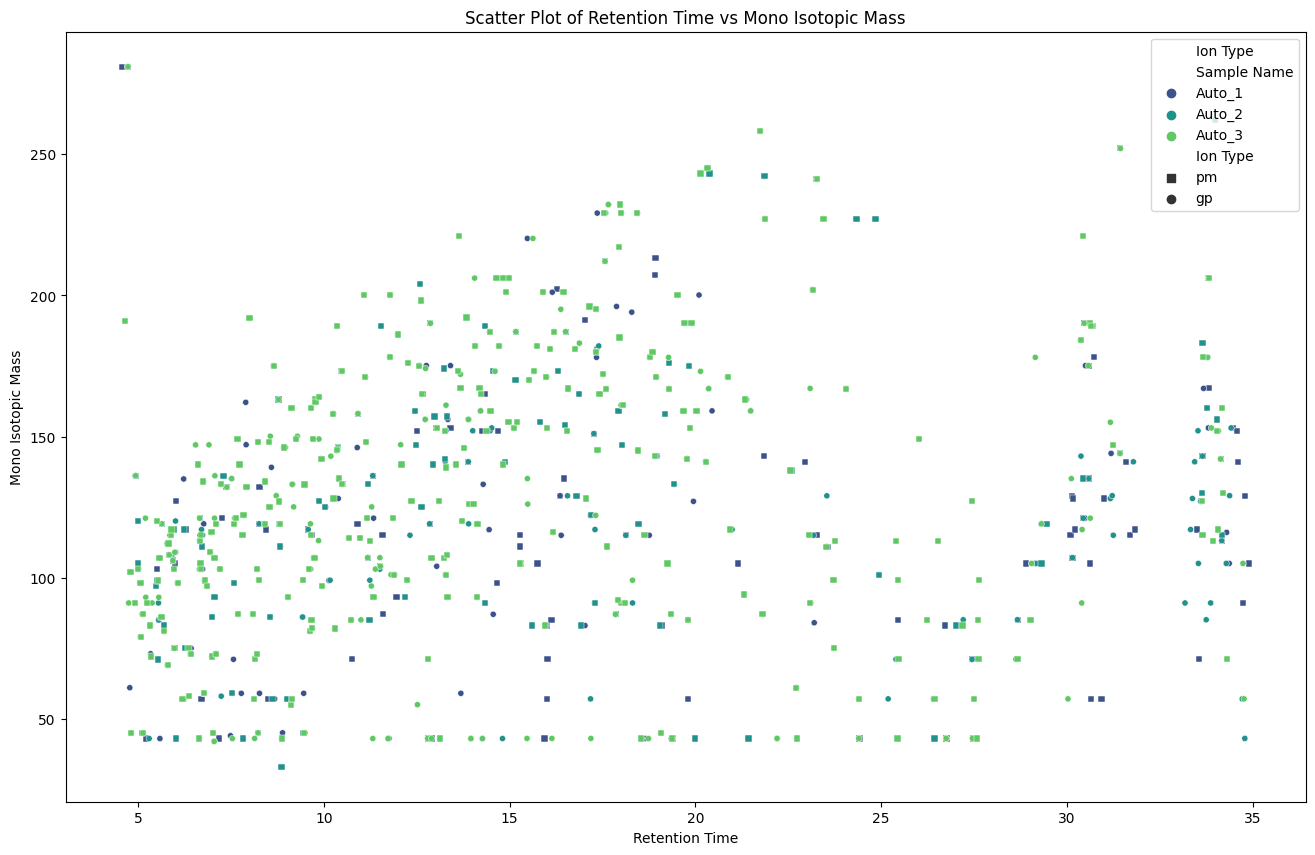

In [6]:
all_dfs = pd.concat([Auto_1_pm_df, Auto_1_gp_df, Auto_2_gp_df, Auto_2_pm_df, Auto_3_gp_df, Auto_3_pm_df])

# Define a dictionary to map 'Ion Type' to shapes
ion_type_shapes = {'gp': 'o', 'pm': 's'}

# Create a scatter plot
plt.figure(figsize=(16, 10))
sns.scatterplot(data=all_dfs, x='Retention Time', y='M/Z', hue='Sample Name', style='Ion Type', markers=ion_type_shapes, palette='viridis', s=20)

# Add labels and title
plt.xlabel('Retention Time')
plt.ylabel('Mono Isotopic Mass')
plt.title('Scatter Plot of Retention Time vs Mono Isotopic Mass')

# Display the legend
plt.legend(title='Ion Type')

# Show the plot
plt.show()

In [7]:
Auto_1_pm_df_f = qc_removal(Auto_1_pm_df, QC_df)
Auto_1_gp_df_f = qc_removal(Auto_1_gp_df, QC_df)
Auto_2_gp_df_f = qc_removal(Auto_2_gp_df, QC_df)
Auto_2_pm_df_f = qc_removal(Auto_2_pm_df, QC_df)
Auto_3_gp_df_f = qc_removal(Auto_3_gp_df, QC_df)
Auto_3_pm_df_f = qc_removal(Auto_3_pm_df, QC_df)

print(len(Auto_1_gp_df_f['Retention Time']))
print(len(Auto_1_gp_df['Retention Time']))
print(len(Auto_2_gp_df_f['Retention Time']))
print(len(Auto_2_gp_df['Retention Time']))
print(len(Auto_3_gp_df_f['Retention Time']))
print(len(Auto_3_gp_df['Retention Time']))

187
199
258
276
200
223


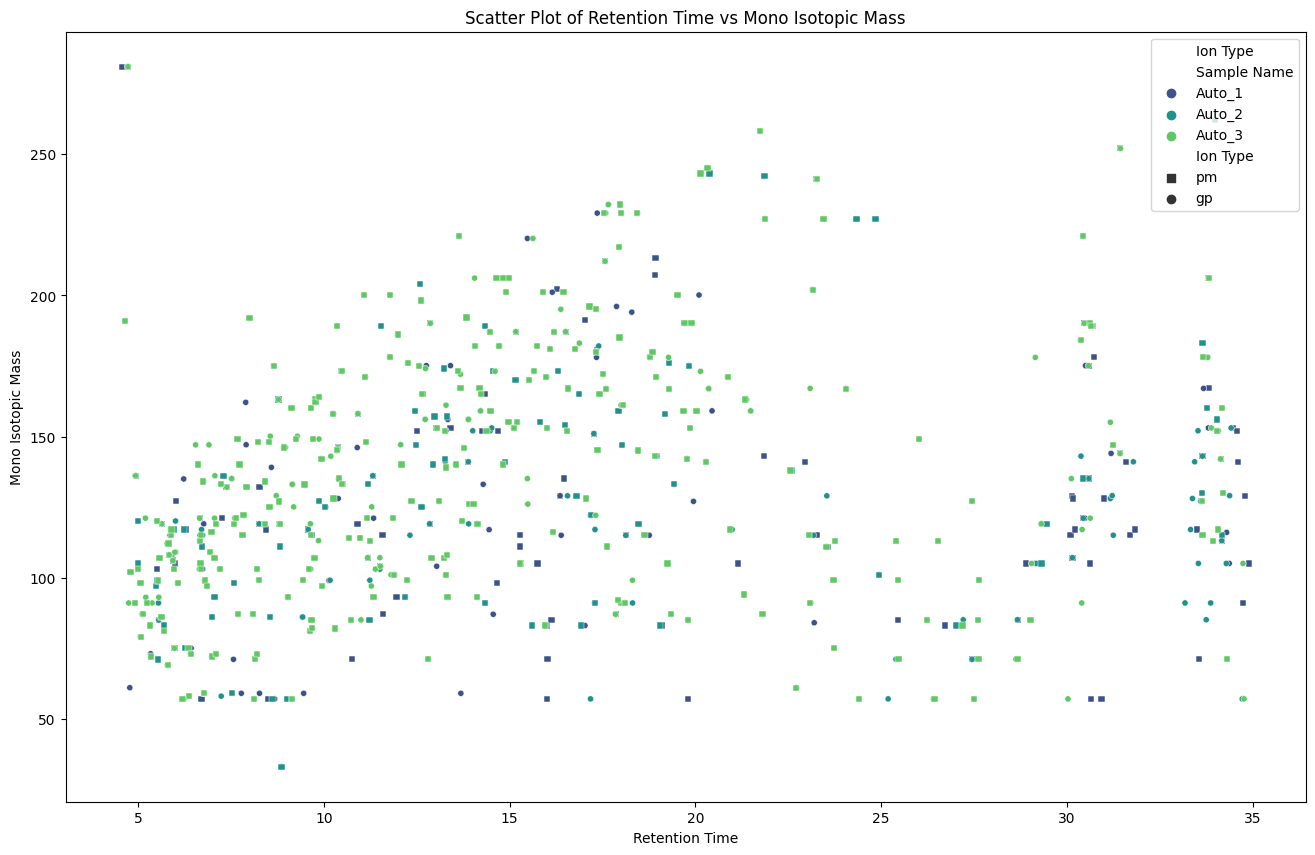

In [8]:
all_dfs_f = pd.concat([Auto_1_pm_df_f, Auto_1_gp_df_f, Auto_2_gp_df_f, Auto_2_pm_df_f, Auto_3_gp_df_f, Auto_3_pm_df_f])

# Define a dictionary to map 'Ion Type' to shapes
ion_type_shapes = {'gp': 'o', 'pm': 's'}

# Create a scatter plot
plt.figure(figsize=(16, 10))
sns.scatterplot(data=all_dfs_f, x='Retention Time', y='M/Z', hue='Sample Name', style='Ion Type', markers=ion_type_shapes, palette='viridis', s=20)

# Add labels and title
plt.xlabel('Retention Time')
plt.ylabel('Mono Isotopic Mass')
plt.title('Scatter Plot of Retention Time vs Mono Isotopic Mass')

# Display the legend
plt.legend(title='Ion Type')

# Show the plot
plt.show()

In [9]:
auto_dfs = [Auto_1_pm_df_f, Auto_1_gp_df_f, Auto_2_gp_df_f, Auto_2_pm_df_f, Auto_3_gp_df_f, Auto_3_pm_df_f]

# Call the process_auto_dfs function
processed_df = process_auto_dfs(auto_dfs)

# Print the processed DataFrame
print(processed_df)

# Check the columns to see if the new match columns are present
print(processed_df.columns)

print(processed_df.head())

Step 1: Created an empty DataFrame.
Shape of Processed DataFrame: (0, 0)

Step 2-3: Appended rows from each Auto DataFrame.
Shape of Processed DataFrame after appending: (1385, 28)

Step 4: Dropped duplicates based on retention time and elemental composition.
Shape of Processed DataFrame after dropping duplicates: (698, 28)

Step 5: Sorted DataFrame based on retention time.
Shape of Processed DataFrame after sorting: (698, 28)

Step 7: Created 'Match_1' column with False values.
Shape of Processed DataFrame after adding match column: (698, 29)


<ipython-input-4-3a2386ab37e0>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  processed_df = processed_df.append(auto_df, ignore_index=True)



Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (698, 29)

Step 7: Created 'Match_2' column with False values.
Shape of Processed DataFrame after adding match column: (698, 30)

Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (698, 30)

Step 7: Created 'Match_3' column with False values.
Shape of Processed DataFrame after adding match column: (698, 31)

Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (698, 31)

Step 7: Created 'Match_4' column with False values.
Shape of Processed DataFrame after adding match column: (698, 32)

Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (698, 32)

Step 7: Created 'Match_5' column with False values.
Shape of Processed DataFrame after adding match column: (698, 33)

Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (698, 33)

Step 7: Creat

In [10]:
processed_df.to_csv('/content/drive/My Drive/processed_peaks.csv')